In [3]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

In [4]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-02-02 11:53:29.618391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 11:53:29.618725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


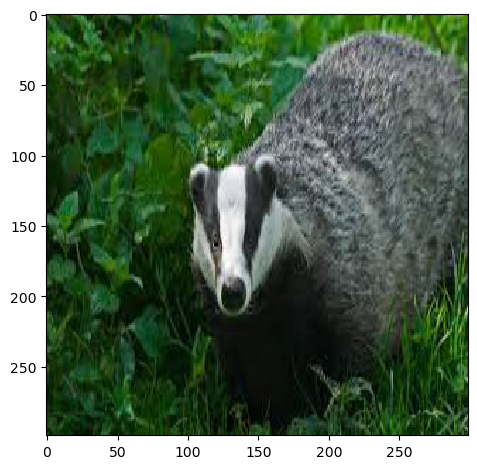

In [5]:
Xi = skimage.io.imread("/Users/yohanabeysinghe/Mac/1. ENTC/FYP - Ear EEG/Datasets/Animal Image Dataset/animals/animals/badger/0c29e0107f.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5)

In [27]:
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
print(preds)
decode_predictions(preds)

1/1 [==============================] - 0s 170ms/step
[[4.85853816e-05 4.24315149e-05 6.55455224e-05 9.50441245e-05
  5.60053304e-05 9.72001799e-05 1.73996650e-05 2.25330787e-05
  8.80892549e-05 3.82599756e-05 3.19723149e-05 3.98087141e-05
  2.38265420e-05 1.46112570e-05 2.08914680e-05 4.46779632e-05
  3.86958745e-05 4.17444862e-05 1.80572548e-04 1.26410159e-04
  9.45278807e-05 4.02970181e-05 1.45245085e-05 3.63200852e-05
  7.54236607e-05 1.00676523e-04 5.47179297e-05 4.41956217e-05
  5.17570079e-05 4.47370148e-05 3.66451859e-05 5.80508968e-05
  7.77419846e-05 4.54342808e-05 7.34624118e-05 4.28042149e-05
  3.93603113e-05 4.77592912e-05 1.22341124e-04 3.21733605e-05
  5.34837418e-05 2.68545373e-05 3.27854650e-05 4.46682898e-05
  1.29823587e-04 6.17140031e-05 4.35239999e-05 6.47700872e-05
  3.02145840e-04 3.48276335e-05 3.77705510e-05 7.08687003e-05
  1.13661838e-04 5.04078962e-05 2.02286625e-04 4.26427032e-05
  9.87404710e-05 5.50739824e-05 3.37497586e-05 1.21164660e-04
  1.01298290e-04 

[[('n02447366', 'badger', 0.92659706),
  ('n02445715', 'skunk', 0.0038643805),
  ('n02441942', 'weasel', 0.0011924052),
  ('n02510455', 'giant_panda', 0.0011460279),
  ('n02783161', 'ballpoint', 0.0011002597)]]

In [7]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes

array([362, 361, 356, 388, 418])

In [8]:
Xi.shape

(299, 299, 3)

In [9]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

60

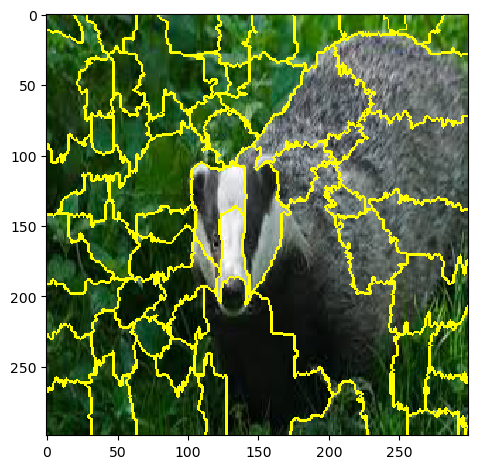

In [10]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [11]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]


array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

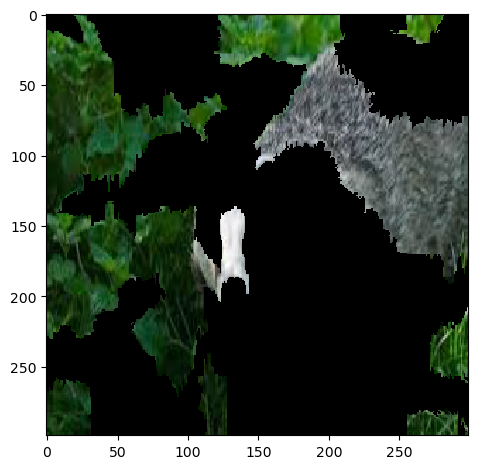

In [12]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image


skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [26]:
perturbed_img = perturb_image(Xi,perturbations[0],superpixels)
inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:]).shape

1/1 [==============================] - 0s 98ms/step


(1, 1000)

In [13]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 32ms/step


(150, 1, 1000)

In [28]:
predictions[0]

array([[2.02322059e-04, 2.06407174e-04, 3.42000189e-04, 5.22577553e-04,
        1.38310902e-03, 6.27153204e-04, 2.65369948e-04, 2.08557904e-04,
        6.61447470e-04, 2.45564058e-03, 9.06816800e-04, 4.02761856e-04,
        4.77632391e-04, 9.42168932e-04, 4.17621690e-04, 5.37635875e-04,
        2.22222588e-04, 3.90298344e-04, 9.72735113e-04, 4.82192001e-04,
        2.64704251e-03, 2.05652625e-03, 3.26786330e-03, 4.30512382e-03,
        5.92385326e-03, 2.55143677e-04, 2.69070064e-04, 8.33403028e-05,
        1.45780505e-04, 1.90741746e-04, 8.43184680e-05, 1.48931125e-04,
        7.54220528e-05, 1.11905334e-04, 9.62676771e-04, 2.59856053e-04,
        1.55839676e-04, 1.31252629e-04, 7.38516159e-04, 4.19449381e-04,
        2.32756036e-04, 1.65678837e-04, 2.41564718e-04, 1.49093196e-03,
        2.33532686e-04, 1.18889395e-04, 1.37903509e-04, 5.77109633e-04,
        3.10653646e-04, 1.21053818e-04, 3.51091992e-04, 1.60951028e-03,
        1.20528348e-04, 6.75313349e-05, 2.77064304e-04, 2.507577

In [14]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [15]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [18]:
perturbations.shape
perturbations[0].size

60

In [19]:
predictions.shape

(150, 1, 1000)

In [23]:
predictions[0, 0].max()

0.11113764

In [30]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.09328833,  0.01590351,  0.0037349 , -0.04755692, -0.06269465,
        0.08772848, -0.04537777,  0.06874505,  0.07600883,  0.07059099,
        0.01407065, -0.09560743, -0.00770286,  0.12616668,  0.02547609,
        0.03767931,  0.12200082,  0.04490294, -0.08373827, -0.0023003 ,
        0.05574751, -0.04928065,  0.01551928, -0.06504623,  0.08948378,
        0.00382263,  0.04969887,  0.07091713, -0.01486135,  0.27802166,
        0.43452865, -0.01469829,  0.04521892, -0.02814962,  0.06168039,
        0.08326904,  0.04250782, -0.02009601,  0.09348204, -0.15016526,
       -0.06586986,  0.07895862,  0.04254923,  0.00819337,  0.01264765,
        0.28302839, -0.03003796, -0.02174791,  0.10168347, -0.00121337,
        0.03310286,  0.05990987, -0.07348097,  0.00431665,  0.04163653,
        0.04518148, -0.03672025, -0.01741773, -0.04617223,  0.04548602])

In [31]:
coeff.shape

(60,)

In [18]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([16, 29, 45, 30])

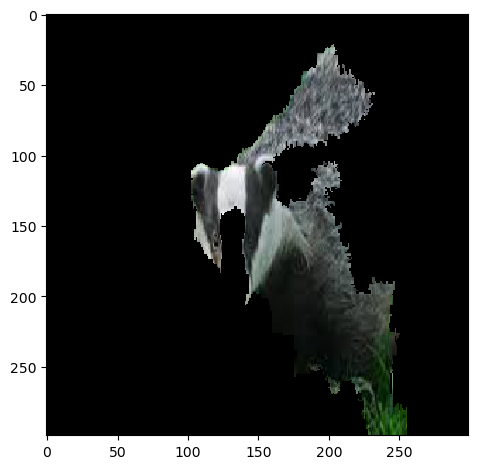

In [19]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


362


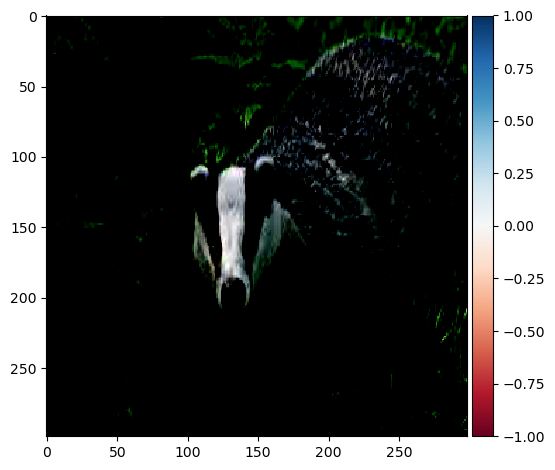

In [34]:
skimage.io.imshow(Xi)

In [35]:
print(top_pred_classes[0])

362


In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

image_to_explain = Xi
label_to_explain = top_pred_classes[0]

explanation = explainer.explain_instance(image_to_explain, inceptionV3_model.predict_proba, top_labels=2, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(label_to_explain, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(lime_image.mark_boundaries(temp / 2 + 0.5, mask))
plt.title("Explanation for class {}".format(label_to_explain))
plt.axis('off')
plt.show()